# MSiA 432 - Deep Learning
## Kristiyan Dimitrov

# Assignment 1 - Due 5/6/2020
## Simple neural network
Build a simple neural network from first principles and understand the underlying mechanisms of how the system works.

In this assignment, students will:
- Build a simple neural network from basic operations using numpy
- Implement the core neural network in 9 simple lines of code
- Make improvements to the simple neural network
- Visualize the network to understand weights, activations, gradients and class separation power

In [1667]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt

In [1668]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
# X is an array of 60,000 28x28 black and white images with pixel values from 0-255
# Y is an array of 60,000 labels with values from 0-9 denoting the image class
(X, Y), (_, _) = mnist.load_data()

Text(0.5, 1.0, 'Class: 3')

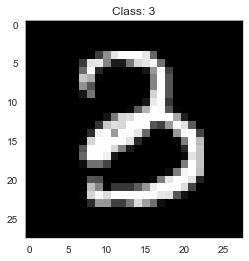

In [1669]:
# Show some random example images from X
random_digit = np.random.randint(0, len(X) - 1)
plt.imshow(X[random_digit], cmap='gray')
# Show image class
plt.title('Class: %01d' % Y[random_digit])

In [1670]:
# Do some basic transforms of data

# We want the pixels in X to have values between 0-1. We'll need to cast to float32 to support the range 0-1.
X = X.astype('float32') / 255.0

# As mentioned in lecture 3, we'll need to flatten X to input it into our basic neural network
X = X.reshape((len(X), -1)).T

# Y should be a 1-hot vector with a 1 indicating the digit class and 0 elsewhere
T = np.zeros((len(Y), 10), dtype='float32').T                   
for i in range(len(Y)): 
    T[Y[i], i] = 1

# Weight definitions
Let's define our basic 3-layer network.

$W1, W2, W3$ are the randomly initialized weight matrices.

We cast to float32 for efficiency as the default type for np.random.rand is 64 bit, and that's slower.

In [1671]:
#%% Setup: 784 -> 256 -> 128 -> 10
# W1 = 2*np.random.rand(784, 256).astype('float32').T - 1 # This is generating from uniform distribution
# W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
# W3 = 2*np.random.rand(128,  10).astype('float32').T - 1

In [1672]:
# # Initialize from Normal Distribution with N(0, 1/sqrt(n)) where n is the number of the input vector
# W1 = np.random.randn(784, 256).astype('float32').T * 1/np.sqrt(784)
# W2 = np.random.randn(256, 128).astype('float32').T * 1/np.sqrt(256)
# W3 = np.random.randn(128,  10).astype('float32').T * 1/np.sqrt(128)
# # Visualizng sample W1 weights
# shape = W1[0].reshape((28,28))
# plt.imshow(shape, cmap="gray")
# print(W1[0][:10])
# plt.show()

In [1673]:
# # Initialize with He Initialization i.e. with N(0, 2/sqrt(n)): https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78
W1 = np.random.randn(784, 256).astype('float32').T * np.sqrt(2/784)
W2 = np.random.randn(256, 128).astype('float32').T * np.sqrt(2/256)
W3 = np.random.randn(128,  10).astype('float32').T * np.sqrt(2/128)
# # Visualizng sample W1 weights
# shape = W1[0].reshape((28,28))
# plt.imshow(shape, cmap="gray")
# print(W1[0][:10])
# plt.show()

In [1674]:
# Define basic sigmoid activation
def sigmoid(x, k): return 1.0/(1.0 + np.e**-(k*x))

# Add other activation functions here
# Tanh activation function (Note that this function can also be defined via the sigmoid like so: # def tanh(x, k=1): return 2*sigmoid(2*x, k) - 1)
def tanh(x, k=1): 
    exponent = np.e**(2*k*x)
    return (exponent - 1) / (exponent + 1) # Reference: https://en.wikipedia.org/wiki/Hyperbolic_functions

# ------------------------
# ReLU Activation function
def ReLU(x, k=1):
    return np.maximum(0.01, x*k)

# ReLU Derivative function
def reluDerivative(x):
    matrix = x
    matrix[matrix<=0] = 0
#     matrix[matrix>0] = 1
    return matrix

# ------------------------
# ReLU_6 activation function
def ReLU_6(x, k=1):
    return np.minimum(np.maximum(0.01, x*k), 6)

# ReLU Derivative function
def ReLU_6_Derivative(x):
    matrix = x
    matrix[np.where((matrix<=0) & (matrix >=6))] = 0
    matrix[np.where(matrix != 0)] = 1
    return matrix

# Core functions
## The next 4 functions are the heart of a basic neural network
- Forward pass: calculates activations
- Backward pass: calculates the gradients
- Update weights: applies the gradient updates to the weight matrices
- Calculate loss: reports how we're doing

## Forward Pass Functions

In [1675]:
# Forward Pass Function for SIGMOID activation function
def forward_pass(X, W1, W2, W3, k): # Adding this k to represent the change in Gradient from adding the k to the sigmoid function
    L1 = sigmoid(W1.dot(X), k)
    L2 = sigmoid(W2.dot(L1), k)
    L3 = sigmoid(W3.dot(L2), k)
    return L1, L2, L3

In [1676]:
# # Forward Pass Function for TANH activation function
# def forward_pass(X, W1, W2, W3, k): 
#     L1 = tanh(W1.dot(X), k)
#     L2 = tanh(W2.dot(L1), k)
#     L3 = tanh(W3.dot(L2), k)
#     return L1, L2, L3

In [1677]:
# # Forward Pass Function for ReLU Activation
# def forward_pass(X, W1, W2, W3, k): 
#     L1 = ReLU(W1.dot(X), k)
#     L2 = ReLU(W2.dot(L1), k)
#     L3 = ReLU(W3.dot(L2), k)
#     return L1, L2, L3

In [1678]:
# # Forward Pass Function for ReLU_6 Activation
# def forward_pass(X, W1, W2, W3, k): 
#     L1 = ReLU_6(W1.dot(X), k)
#     L2 = ReLU_6(W2.dot(L1), k)
#     L3 = ReLU_6(W3.dot(L2), k)
#     return L1, L2, L3

## Backward Pass Functions

In [1679]:
# # Backward Pass Function for SIGMOID activation function
# def backward_pass(L1, L2, L3, W1, W2, W3, k): # Adding this k to represent the change in Gradient from adding the k to the sigmoid function
#     dW3 = (L3 - T) * L3*(1 - L3) * k 
#     dW2 = W3.T.dot(dW3)*(L2*(1-L2)) * k 
#     dW1 = W2.T.dot(dW2)*(L1*(1-L1)) * k 
#     return dW1, dW2, dW3

In [1680]:
# Backward Pass Function for TANH activation function
# def backward_pass(L1, L2, L3, W1, W2, W3, k):
#     dW3 = (L3 - T) * (1-L3**2) * k # NOTE!: This line has been modified to represent the derivative of TANH, which is 1-tanh^2(x)
#     dW2 = W3.T.dot(dW3)*(1-L2**2) * k # NOTE!: This line has been modified to represent the derivative of TANH, which is 1-tanh^2(x)
#     dW1 = W2.T.dot(dW2)*(1-L1**2) * k # NOTE!: This line has been modified to represent the derivative of TANH, which is 1-tanh^2(x)
#     return dW1, dW2, dW3

In [1681]:
# Backward Pass Function for SIGMOID activation function with Cross_Entropy as loss function
def backward_pass(L1, L2, L3, W1, W2, W3, k):
    dW3 = (L3 - T) * k
    dW2 = W3.T.dot(dW3)*(L2*(1-L2)) * k 
    dW1 = W2.T.dot(dW2)*(L1*(1-L1)) * k 
    return dW1, dW2, dW3

In [1682]:
# # Backward Pass Function for ReLU Activation function
# def backward_pass(L1, L2, L3, W1, W2, W3, k):
#     dW3 = (L3 - T) * reluDerivative(L3) * k
#     dW2 = W3.T.dot(dW3) * reluDerivative(L2) * k 
#     dW1 = W2.T.dot(dW2) * reluDerivative(L1) * k 
#     return dW1, dW2, dW3

In [1683]:
# # Backward Pass Function for ReLU_6 Activation function
# def backward_pass(L1, L2, L3, W1, W2, W3, k):
#     dW3 = (L3 - T) * ReLU_6_Derivative(L3) * k
#     dW2 = W3.T.dot(dW3) * ReLU_6_Derivative(L2) * k 
#     dW1 = W2.T.dot(dW2) * ReLU_6_Derivative(L1) * k 
#     return dW1, dW2, dW3

## Next Functions

In [1684]:
def update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2):
    W3 -= lr*np.dot(dW3, L2.T)
    W2 -= lr*np.dot(dW2, L1.T)
    W1 -= lr*np.dot(dW1, X.T)
    return W1, W2, W3

In [1685]:
# Monitoring variables
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []

In [1686]:
# # MSE Loss function
# def calculate_loss():
#     global losses
#     loss = np.sum((L3 - T)**2)/len(T.T)
#     losses.append(loss)
#     #print("[%04d] MSE Loss: %0.6f" % (i, loss)) 

In [1687]:
# Cross-Entropy (Deviance?) loss function (NON BINARY CASE)
def calculate_loss():
    global losses
    loss =  -np.sum(np.nan_to_num(T*np.log(L3)))/len(T.T)
    losses.append(loss)
#     #print("[%04d] MSE Loss: %0.6f" % (i, loss)) 

In [1688]:
# Helper function to draw confusion matrix
def confusion_matrix():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, accuracies, losses, accpct
    import seaborn
    os.makedirs('train', exist_ok=True)
    predictions = np.zeros(L3.shape, dtype='float32')
    for j, m in enumerate(np.argmax(L3.T, axis=1)): predictions[m,j] = 1
    acc = np.sum(predictions*T)
    accpct = 100*acc/X.shape[1]
    accuracies.append(accpct)   

    data = np.zeros((10,10,))
    for z, c in enumerate(np.argmax(T.T, axis=1)): data[c][np.argmax(predictions.T[z])] += 1
    for z, s in enumerate(data.sum(axis=0)): data[:,z] /= (s + 1e-5)
    seaborn.set_style("whitegrid", {'axes.grid' : False})
    seaborn.heatmap(data, annot=data*100, fmt='0.0f', cmap='Wistia')
    plt.xlabel('Actual'), plt.ylabel('Predicted'), plt.title('Confusion matrix (ACC %0.2f%%)' % accpct)
    plt.savefig(os.path.join('train', 'confusion-%05d.png' % i))
    plt.show(), plt.close()

In [1689]:
# Helper function to visualize training
def triple_plot():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, accuracies, losses, accpct, mean_activ, hw1, hw2, hw3
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
    testi = np.random.choice(range(60000))
    ax1.imshow(X.T[testi].reshape(28,28), cmap='gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    cls = np.argmax(L3.T[testi])
    ax1.set_title("Prediction: %d confidence=%0.2f" % (cls, L3.T[testi][cls]/np.sum(L3.T[testi])))

    ax2.plot(losses, color='blue')
    ax2.set_title("Loss"), ax2.set_yscale('log')
    ax3.plot(accuracies, color='blue')
    ax3.set_ylim([0, 100])
    ax3.axhline(90, color='red', linestyle=':')     # Aim for 90% accuracy in 200 epochs        
    ax3.set_title("Accuracy: %0.2f%%" % accpct)
    plt.show(), plt.close()

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(10,10))
    ax1.imshow(np.reshape(L1.mean(axis=1), (16, 16,)), cmap='gray', interpolation='none'), ax1.set_title('L1 $\mu$=%0.2f $\sigma$=%0.2f' % (L1.mean(), L1.std()))
    ax2.imshow(np.reshape(L2.mean(axis=1), (16, 8,)),  cmap='gray', interpolation='none'), ax2.set_title('L2 $\mu$=%0.2f $\sigma$=%0.2f' % (L2.mean(), L2.std()))
    ax3.imshow(np.reshape(L3.mean(axis=1), (10, 1,)),  cmap='gray', interpolation='none'), ax3.set_title('L3 $\mu$=%0.2f $\sigma$=%0.2f' % (L3.mean(), L3.std())), ax3.set_xticks([])
    activations = np.concatenate((L1.flatten(), L2.flatten(), L3.flatten()))
    try:
        ax4.hist(activations)
    except ValueError:
        pass
    ax4.set_title('Activation histogram')

    ax5.imshow(np.reshape(W1.mean(axis=0), (28, 28,)), cmap='gray', interpolation='none'), ax5.set_title('W1 $\mu$=%0.2f $\sigma$=%0.2f' % (W1.mean(), W1.std()))
    ax6.imshow(np.reshape(W2.mean(axis=0), (16, 16,)), cmap='gray', interpolation='none'), ax6.set_title('W2 $\mu$=%0.2f $\sigma$=%0.2f' % (W2.mean(), W2.std()))
    ax7.imshow(np.reshape(W3.mean(axis=0), (16, 8, )), cmap='gray', interpolation='none'), ax7.set_title('W3 $\mu$=%0.2f $\sigma$=%0.2f' % (W3.mean(), W3.std())), ax7.set_xticks([])
    ax8.plot(accuracies, color='blue'), ax8.set_title("Accuracy: %0.2f%%" % accpct), ax8.set_ylim(0, 100)

    uw1, uw2, uw3 = np.dot(dW1, X.T), np.dot(dW2, L1.T), np.dot(dW3, L2.T)
    hw1.append(lr*np.abs(uw1).mean()), hw2.append(lr*np.abs(uw2).mean()), hw3.append(lr*np.abs(uw3).mean())
    ax9.imshow(np.reshape(uw1.sum(axis=0),  (28, 28,)), cmap='gray', interpolation='none'), ax9.set_title ('$\Delta$W1: %0.2f E-5' % (1e5 * lr * np.abs(uw1).mean()), color='r')
    ax10.imshow(np.reshape(uw2.sum(axis=0), (16, 16,)), cmap='gray', interpolation='none'), ax10.set_title('$\Delta$W2: %0.2f E-5' % (1e5 * lr * np.abs(uw2).mean()), color='g')
    ax11.imshow(np.reshape(uw3.sum(axis=0), (16, 8, )), cmap='gray', interpolation='none'), ax11.set_title('$\Delta$W3: %0.2f E-5' % (1e5 * lr * np.abs(uw3).mean()), color='b'), ax11.set_xticks([])    
    ax12.plot(hw1, color='r', label='dW1'), ax12.plot(hw2, color='g', label='dW2'), ax12.plot(hw3, color='b', label='dW3'), ax12.set_title('Weight update magnitude')
    ax12.legend(loc='upper right'), ax12.set_yscale('log')

    plt.suptitle("Weight and update visualization ACC: %0.2f%% LR=%0.8f" % (accpct, lr))
    plt.savefig(os.path.join('train', 'train-%05d.png' % i))
    plt.show(), plt.close()

In [1690]:
# Helper function to visualize via T-SNE
def tsne_viz():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, accuracies, losses
    from matplotlib import cm
    import sklearn.manifold
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(L2.T[:500])
    for digit in range(10):
        xx = X_embedded[Y[:500] == digit, 0]
        yy = X_embedded[Y[:500] == digit, 1]
        plt.scatter(xx, yy, c=[next(colors)], label=digit)
        t = plt.text(np.median(xx), np.median(yy), digit, fontsize=24)
        t.set_bbox({'facecolor': 'white', 'alpha': 0.75})
    plt.title('T-SNE viz - Accuracy: %0.2f%%' % accpct), plt.legend()            
    plt.savefig(os.path.join('train', 'tsne-%05d.png' % i))
    plt.show(), plt.close()

In [1691]:
def checknan(x):
    # Checks if matrix contains NaN
    return np.any(np.isnan(x))

In [1692]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

# Main loop
This is the main training loop. The three key lines are the forward pass, backward pass and weight updates.

Hint: If your optimization is blowing up or getting NaNs, try decreasing the learning rate.

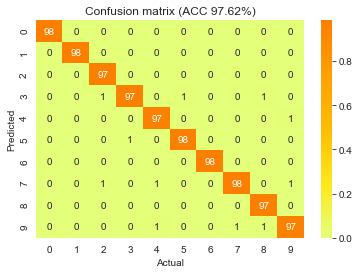

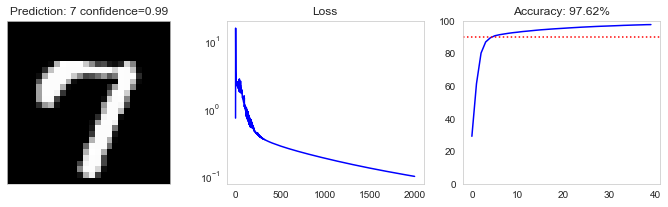

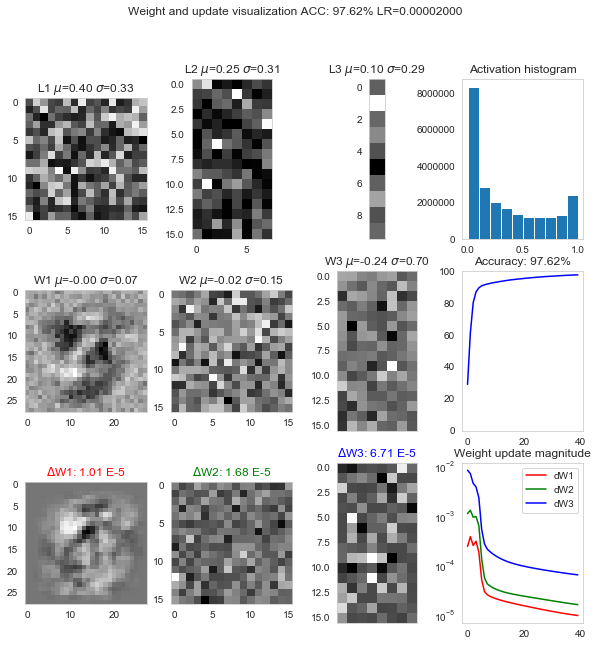

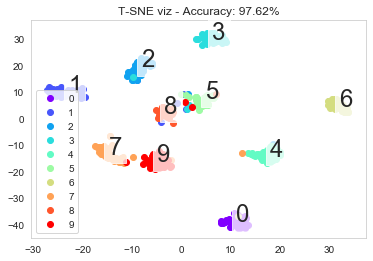

In [1693]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(50)

# Learning rate, decrease if optimization isn't working
# Problem 2, Part (1) - PARAMETERS
constant = 2
lr = 1e-5 * constant
# Problem 2, Part (2) - PARAMETERS
k = 1

for i in range(2000):
    L1, L2, L3    = forward_pass(X, W1, W2, W3, k)
    dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3, k)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)
    
    progbar.update(i % 50)
    calculate_loss()

    if i % 50 == 49:
        if checknan(L1) or checknan(L2) or checknan(L3):
            print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
            print('Optimization halted')
            break
        clear_output(wait=True)
        confusion_matrix()
        triple_plot()
        tsne_viz()

# Graveyard

In [ ]:
# # Initializing with random numbers from uniform distribution [0, 1] and centering to [-1, 1]
# This should produce the same results as above!
# W1 = 2*np.random.uniform(0, 1, (784, 256)).astype('float32').T - 1
# W2 = 2*np.random.uniform(0, 1, (256, 128)).astype('float32').T - 1
# W3 = 2*np.random.uniform(0, 1, (128,  10)).astype('float32').T - 1
# # Visualizng sample W1 weights
# shape = W1[0].reshape((28,28))
# plt.imshow(shape, cmap="gray")
# print(W1[0][:3])
# plt.show()

In [ ]:
# # Cross-Entropy (Deviance?) loss function in the Binary classification instance (Ignore, this was just my initial guess)
# def calculate_loss():
#     global losses
#     loss = np.sum(-1*T*np.log(L3) - (1-T)*np.log(1-L3))/len(T.T)
#     losses.append(loss)
#     #print("[%04d] MSE Loss: %0.6f" % (i, loss)) 

In [ ]:
# Comparison between binary and non binary case
#     loss = np.sum(-1*T*np.log(L3) - (1-T)*np.log(1-L3))/len(T.T)
#     loss = np.sum(-1*T*np.log(L3)                     )/len(T.T)

In [ ]:
# TEST NORMAL INITIATION
# W1 = np.sqrt(1/784)* np.random.normal(loc = 0, scale = 1, size = (784, 256)).astype('float32').T
# W2 = np.sqrt(1/256)* np.random.normal(loc = 0, scale = 1, size = (256, 128)).astype('float32').T
# W3 = np.sqrt(1/128)* np.random.normal(loc = 0, scale = 1, size = (128,  10)).astype('float32').T